**Test**: Equal Number of Real News and Fake News from Global South, and checking PRA values.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install keras
!pip install tensorflo


ERROR: Could not find a version that satisfies the requirement tensorflo (from versions: none)
ERROR: No matching distribution found for tensorflo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History

from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.layers import Embedding
from keras.layers import Reshape, Flatten
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D
from keras.layers import AveragePooling1D, Input, Dropout, concatenate

from wordcloud import WordCloud, STOPWORDS

import pickle
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#read data

###North

In [ ]:
'''
This cell is primarily from global north
'''
# For ISOT Dataset
df1 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/Fake.csv', delimiter=',')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GN.csv', delimiter = ',')
df1['label'] = 0
df2['label'] = 1
df_isot = pd.concat([df1,df2])
df_isot = df_isot[['text','label']]
print(df_isot.shape)

num_class_A_train = np.sum(df_isot['label'] == 0)
num_class_B_train = np.sum(df_isot['label'] == 1)
print(num_class_A_train)
print(num_class_B_train)

(40025, 2)
23481
16544


In [ ]:
"""
Uncomment cell to oversample real data in GN
"""
# # Separate features and labels
# X = df_isot[['text']]
# y = df_isot['label']

# oversampler = RandomOverSampler(random_state=42)

# # Resample the data
# X_resampled, y_resampled = oversampler.fit_resample(df_isot[['text']], df_isot['label'])

# # Create a new DataFrame with resampled data
# df_isot = pd.DataFrame(X_resampled, columns=['text'])
# df_isot['label'] = y_resampled

# # Check the class distribution after oversampling
# print(df_isot['label'].value_counts())

###South

In [ ]:
'''
This cell is primarily from global south
'''
# For GS Dataset
df1 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/FNI/fakenewsincidents_india_dataset_v1.csv', delimiter=',')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GS_Complete.csv', delimiter = ',')
df1['label'] = 0
df1 = df1.rename(columns={'Content': 'text'})
df2['label'] = 1
df_all_features_gs = pd.concat([df1,df2])
df_gs = df_all_features_gs[['text','label']]

X = df_gs[['text']]
y = df_gs['label']

num_class_A_train = np.sum(df_gs['label'] == 0)
num_class_B_train = np.sum(df_gs['label'] == 1)
print(num_class_A_train)
print(num_class_B_train)

4802
5741


In [ ]:
'''Uncomment for oversampling class with lesser count'''

# oversampler = RandomOverSampler(random_state=42)

# # Resample the data
# X_resampled, y_resampled = oversampler.fit_resample(df_gs[['text']], df_gs['label'])

# # Create a new DataFrame with resampled data
# df_gs = pd.DataFrame(X_resampled, columns=['text'])
# df_gs['label'] = y_resampled

# # Check the class distribution after oversampling
# print(df_gs['label'].value_counts())

# df_gs.head()

In [ ]:
# X = df_gs[['text']]
# y = df_gs['label']

# X_isot = df_isot[['text']]
# y_isot = df_isot['label']

# targetCount = 6200
# strategy = {0: targetCount, 1: targetCount}
# ros = RandomOverSampler(sampling_strategy=strategy, random_state=42)
# rus = RandomUnderSampler(sampling_strategy=strategy, random_state=42)

# X_resampled, y_resampled = ros.fit_resample(X, y)
# Xus, yus = rus.fit_resample(X_isot, y_isot)

# df_gs = pd.DataFrame(X_resampled, columns=['text'])
# df_gs['label'] = y_resampled

# df_isot = pd.DataFrame(Xus, columns=['text'])
# df_isot['label'] = yus

# print('-----------------------------')
# print(df_gs['label'].value_counts())
# print('-----------------------------')
# print(df_isot['label'].value_counts())
# print('-----------------------------')

# df_isot['text'] = df_isot['text'].astype(str)
# df_gs['text'] = df_gs['text'].astype(str)

###Tokenizer

In [ ]:
df = pd.concat([df_gs, df_isot])
df['text'] = df['text'].astype('str')

In [ ]:
# Maximum number of words to be embedded
NUM_WORDS = 30000
EMBEDDING_DIM=100
# max length to be encoded for a sentence
MAX_SEQUENCE_LENGTH = 1000

# Define Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(df['text'])

sequences_gn = tokenizer.texts_to_sequences(df_isot['text'])
data_gn = pad_sequences(sequences_gn, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

sequences_gs = tokenizer.texts_to_sequences(df_gs['text'].astype(str))
data_gs = pad_sequences(sequences_gs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

# # Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 162301 unique tokens.


In [ ]:
X_train_gn, X_test_gn, y_train_gn, y_test_gn = train_test_split(
    data_gn,  # Features (input)
    df_isot['label'],  # Target variable (output)
    test_size=0.2,  # Proportion of the dataset to include in the test split (20% in this example)
    random_state=42  # Seed used by the random number generator for reproducibility
)

X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(
    data_gs,  # Features (input)
    df_gs['label'],  # Target variable (output)
    test_size=0.2,  # Proportion of the dataset to include in the test split (20% in this example)
    random_state=42  # Seed used by the random number generator for reproducibility
)

### glove embedding

In [ ]:
word_vectors = dict()

# load the whole embedding into memory
f = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))

Loaded 400000 word vectors.


In [ ]:
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))
#vocabulary_size= len(word_index)+1
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
      # if the word is not found, set to all 0s
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i]=vec

#del(word_vectors)

In [ ]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
# embedding_matrix.shape

In [ ]:
# X_train.shape

In [ ]:
# del(embedding_matrix)

### Glove Embeddings for split network (Uncomment for model FNDNet_Split)

In [ ]:
# word_vectors = dict()

# # load the whole embedding into memory
# f = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     word_vectors[word] = coefs
# f.close()
# print('Loaded %s word vectors.' % len(word_vectors))

Loaded 400000 word vectors.


In [ ]:
# word_index_GN = tokenizer.word_index
# word_index_GS = tokenizer.word_index

In [ ]:
# vocabulary_size=min(len(word_index_GN)+1,(NUM_WORDS))
# embedding_matrix_GN = np.zeros((vocabulary_size, EMBEDDING_DIM))

# for word, i in word_index_GN.items():
#     if i>=NUM_WORDS:
#         continue
#     try:
#         embedding_vector = word_vectors[word]
#         embedding_matrix_GN[i] = embedding_vector
#     except KeyError:
#       # if the word is not found, set to all 0s
#         vec = np.zeros(EMBEDDING_DIM)
#         embedding_matrix_GN[i]=vec

# #del(word_vectors)

# vocabulary_size=min(len(word_index_GS)+1,(NUM_WORDS))
# #vocabulary_size= len(word_index_GS)+1
# embedding_matrix_GS = np.zeros((vocabulary_size, EMBEDDING_DIM))

# for word, i in word_index_GS.items():
#     if i>=NUM_WORDS:
#         continue
#     try:
#         embedding_vector = word_vectors[word]
#         embedding_matrix_GS[i] = embedding_vector
#     except KeyError:
#       # if the word is not found, set to all 0s
#         vec = np.zeros(EMBEDDING_DIM)
#         embedding_matrix_GS[i]=vec

In [ ]:
# # Dfine Embedding function using the embedding_matrix
# embedding_layer_A = Embedding(vocabulary_size,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix_GN],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)

# embedding_layer_B = Embedding(vocabulary_size,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix_GS],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)


# Model Definitions (Uncomment model being tested)*italicized text*

In [ ]:
'''FNDNet (Original)'''

# num_kernels = 128
# kernel_sizes= [3,4,5]
# pool_sizes = [800,799,798]

# #embed_input = Input(shape=(max_length,))
# #x = Embedding(vocab_size,output_dim,input_length=max_length)(embed_input)

# inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
# embed_input = embedding_layer(inputs)

# pool_outputs = []
# for i in range(len(kernel_sizes)):
#     conv = Conv1D(num_kernels, kernel_size=kernel_sizes[i], padding='valid', activation='relu')(embed_input)
#     pool = MaxPooling1D(pool_size=pool_sizes[i], strides=1, padding = 'valid')(conv)
#     pool_outputs.append(pool)
# merge = concatenate(pool_outputs,axis = 1)

# conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(merge)
# pool = MaxPooling1D(pool_size=5)(conv)
# conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(pool)
# pool = MaxPooling1D(pool_size=30)(conv)

# x = Flatten()(pool)
# #x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(1, activation='sigmoid')(x)
# modelC = Model(inputs=inputs,outputs=x)

# modelC.compile(loss='binary_crossentropy',
#               #optimizer='Adadelta',
#               optimizer='Adam',
#               metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
'''Simple Model'''
# modelC = Sequential()
# modelC.add(embedding_layer)
# modelC.add(Flatten())
# modelC.add(Dense(1, activation='sigmoid'))
# # compile the modelC
# # modelC.compile(optimizer='adam', loss='binary_crossentropy',
#               # metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# # summarize the modelC
# # modelC.summary()

In [ ]:
'''FNDNet (Split)'''

# num_kernels = 128
# kernel_sizes = [3, 4, 5]
# pool_sizes = [800, 799, 798]

# MAX_SEQUENCE_LENGTH = 1000

# inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')

# # Define your embedding layers A and B
# embedding_layer_A = embedding_layer_A  # Your embedding layer A
# embedding_layer_B = embedding_layer_B  # Your embedding layer B

# # Embedding layer A
# embed_input_A = embedding_layer_A(inputs)

# # Embedding layer B
# embed_input_B = embedding_layer_B(inputs)

# # First half of the network for embedding A
# pool_outputs1_A = []
# for i in range(len(kernel_sizes)):
#     conv_A = Conv1D(num_kernels, kernel_size=kernel_sizes[i], padding='valid', activation='relu')(embed_input_A)
#     pool_A = MaxPooling1D(pool_size=pool_sizes[i], strides=1, padding='valid')(conv_A)
#     pool_outputs1_A.append(pool_A)
# merge1_A = concatenate(pool_outputs1_A, axis=1)

# conv_A = Conv1D(num_kernels, kernel_size=5, activation='relu')(merge1_A)
# pool_final1_A = MaxPooling1D(pool_size=30)(conv_A)

# # First half of the network for embedding B
# pool_outputs1_B = []
# for i in range(len(kernel_sizes)):
#     conv_B = Conv1D(num_kernels, kernel_size=kernel_sizes[i], padding='valid', activation='relu')(embed_input_B)
#     pool_B = MaxPooling1D(pool_size=pool_sizes[i], strides=1, padding='valid')(conv_B)
#     pool_outputs1_B.append(pool_B)
# merge1_B = concatenate(pool_outputs1_B, axis=1)

# conv_B = Conv1D(num_kernels, kernel_size=5, activation='relu')(merge1_B)
# pool_final1_B = MaxPooling1D(pool_size=30)(conv_B)

# # Concatenate the outputs of both halves
# merged_final = concatenate([pool_final1_A, pool_final1_B], axis=1)

# # Common second half of the network
# x = Flatten()(merged_final)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
# outputs = Dense(1, activation='sigmoid')(x)

# # Create model with inputs and outputs
# FNDNet_split = Model(inputs=inputs, outputs=outputs)

# # Print model summary
# FNDNet_split.summary()

# modelC = FNDNet_split

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1000, 100)            3000000   ['input_2[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 1000, 100)            3000000   ['input_2[0][0]']             
                                                                                                  
 conv1d_5 (Conv1D)           (None, 998, 128)             38528     ['embedding_1[0][0]']         
                                                                                            

In [ ]:
'''
Lists to check performance in graphical format
'''
x = []
pr_list = []
recall_list = []

pr_gn = []
recall_gn = []

pr_gs = []
recall_gs = []

In [ ]:
'''
Training and testing; Change the amount of data being used to check for performance in that range
'''
epochs = 40
batch_size = 128


early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,         # Number of epochs with no improvement after which training will be stopped
                               verbose=0,          # Will print messages when early stopping triggers
                               mode='min',         # The direction is automatically inferred if not set but can be set to 'min' or 'max'
                               restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity.

for i in range(0,10):
    # Uncomment for GS incremental testing
    dataset_used = "GS"
    if i != 0:
      curr_x_train, _ , curr_y_train, _ = train_test_split(X_train_gs, y_train_gs, train_size=(i/10), random_state=42) # Edit train size
      X_train = np.concatenate([X_train_gn, curr_x_train])
      X_test = np.concatenate([X_test_gn, X_test_gs])
      y_train = np.concatenate([y_train_gn, curr_y_train])
      y_test = np.concatenate([y_test_gn, y_test_gs])
    else:
      X_train = np.concatenate([X_train_gn])
      X_test = np.concatenate([X_test_gn, X_test_gs])
      y_train = np.concatenate([y_train_gn])
      y_test = np.concatenate([y_test_gn, y_test_gs])

    # Uncomment for GN incremental testing
    # dataset_used = "GN"
    # if i != 0:
    #   curr_x_train, _ , curr_y_train, _ = train_test_split(X_train_gn, y_train_gn, train_size=(i/10), random_state=42) # Edit train size
    #   X_train = np.concatenate([X_train_gs, curr_x_train])
    #   X_test = np.concatenate([X_test_gn, X_test_gs])
    #   y_train = np.concatenate([y_train_gs, curr_y_train])
    #   y_test = np.concatenate([y_test_gn, y_test_gs])
    # else:
    #   X_train = np.concatenate([X_train_gs])
    #   X_test = np.concatenate([X_test_gn, X_test_gs])
    #   y_train = np.concatenate([y_train_gs])
    #   y_test = np.concatenate([y_test_gn, y_test_gs])

    xtrain, xvald, ytrain, yvald = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    modelC.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    # Fit the model with the early stopping callback
    modelC.fit(xtrain, ytrain,
              epochs=epochs,
              validation_data=(xvald, yvald),
              batch_size=batch_size,
              verbose=1,
              callbacks=[early_stopping])
    loss, pr, recall = modelC.evaluate(X_test, y_test)
    loss, pr1, recall1 = modelC.evaluate(X_test_gn, y_test_gn)
    loss, pr2, recall2 = modelC.evaluate(X_test_gs, y_test_gs)

    x.append((i/10)*X_train_gs.shape[0]) # Use same as train size

    pr_gn.append(pr1)
    recall_gn.append(recall1)
    pr_gs.append(pr2)
    recall_gs.append(recall2)
    pr_list.append(pr)
    recall_list.append(recall)

Epoch 1/40
201/201 [==============================] - 62s 294ms/step - loss: 0.2098 - precision_10: 0.9233 - recall_10: 0.8992 - val_loss: 0.0355 - val_precision_10: 0.9943 - val_recall_10: 0.9776
Epoch 2/40
201/201 [==============================] - 59s 295ms/step - loss: 0.0134 - precision_10: 0.9951 - recall_10: 0.9954 - val_loss: 0.0212 - val_precision_10: 0.9922 - val_recall_10: 0.9910
Epoch 3/40
201/201 [==============================] - 58s 290ms/step - loss: 0.0040 - precision_10: 0.9984 - recall_10: 0.9989 - val_loss: 0.0278 - val_precision_10: 0.9959 - val_recall_10: 0.9869
Epoch 4/40
201/201 [==============================] - 58s 291ms/step - loss: 0.0014 - precision_10: 0.9996 - recall_10: 0.9995 - val_loss: 0.0281 - val_precision_10: 0.9914 - val_recall_10: 0.9944
Epoch 5/40
201/201 [==============================] - 58s 291ms/step - loss: 3.6525e-04 - precision_10: 1.0000 - recall_10: 0.9999 - val_loss: 0.0280 - val_precision_10: 0.9929 - val_recall_10: 0.9937
Epoch 6/40


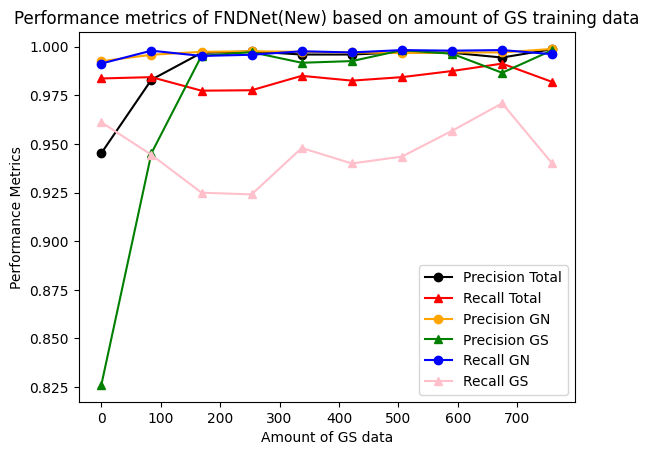

In [ ]:
plt.plot(x, pr_list, label='Precision Total', color='black', marker='o')
plt.plot(x, recall_list, label='Recall Total', color='red', marker='^')
plt.plot(x, pr_gn, label='Precision GN', color='orange', marker='o')
plt.plot(x, pr_gs, label='Precision GS', color='green', marker='^')
plt.plot(x, recall_gn, label='Recall GN', color='blue', marker='o')
plt.plot(x, recall_gs, label='Recall GS', color='pink', marker='^')

# Adding labels and title
plt.xlabel(f'Amount of {dataset_used} data')
plt.ylabel('Performance Metrics')
plt.title(f'Performance metrics of FNDNet(New) based on amount of {dataset_used} training data')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()